# Expectation-Maximization algorithm from scratch for recommendations via matrix completion

First, we provide some background on the algorithms being used in this project. Then, we build the Expectation-Maximization algorithm from scratch using only numpy. We use our algorithm to construct a Gaussian mixture model which we use to fill an incomplete rating matrix for the purpose of providing recommendations. Finally, we compare our model with the most popular clustering model provided by sklearn: sklearn.clustering.KMeans.

## k-means clustering algorithm

Given the data points $x_1,\ldots,x_n$, $k$-means clustering partitions the $n$ points into $k\leq n$ parts $P_1,\ldots, P_k$ so that the sum of the variance with each cluster is minimal. The algorithm is an iterative process with each iteration consisting of two steps. 

#### Assignment Step
We calculate the distance between each point $x_i$ and the mean of each cluster $P_j$ where $i=1,\ldots,n$ and $j=1,\ldots, k$. Then we assign each point to the nearest cluster. In particular, we use the Euclidean distance.
$$
d(x,y)=(\sum_{i=1}^d |x_i-y_i|)^\frac{1}{2}
$$
Here $x$ and $y$ are samples with $d$ dimensions and $x_i$ and $y_i$ are the $i$th dimension of each.

#### Update Step
We recalculate all the means for each cluster.
$$
\mu_j = \frac{1}{n_j}\sum_{i=1}^{n_j} x_i
$$
$\mu_j$ is the mean for cluster $P_j$ and $n_j=|P_j|$.

#### Initialization
We initialize the means by randomly choosing $k$ distinct samples from the data and using them as the initial $k$ means. We choose this method compared to others (like randomly assigning each point to a part) because it has a higher probability of spreading the intial means out in comparison.

### Considerations
Another popular metric is derived from cosine similarity. However, cosine similarity ignores magnitude which is very important in this case. For example, the points $(1,1)$ and $(5,5)$ would have a maximal cosine similarity of $1$ but are completely different in terms of ratings. Hence in this case, Euclidean is the better choice.

## Mixture models
A mixture model can be thought of as a generalization of the $k$-means clustering algorithm. In particular, we will use the Gaussian mixture model. This means that we are assuming that the each sample is a linear combination of Gaussian distributions.

#### Log-likelihood function
Instead of measuring the distance between sample $x_i$ and the mean $\mu_j$ of cluster $P_j$, we consider the probability or $\textit{likelihood}$ that $x_i$ belongs to $P_j$. For each cluster $P_j$ we still have the mean $\mu_j$. However, we also have the variance $\sigma^2_j$ as well as probabilities or $\textit{weights}$ $\pi_j$. The likelihood function $L(X,\Theta)$ is the probability that the instance $X$ occurs given the current $k$ distributions $\Theta$. Recall that in the $k$-means clustering algorithm, our goal was to minimized the total error which we computed as the sum of the variances of each cluster. Analogously, for our mixture model we want to maximize our likelihood function. In other words we want to find the parameters $\mu_j, \sigma^2_j, \pi_j$ which maximizes the chance that our data was generated by 
$$
\sum_{j=1}^k \pi_j N(\mu_j,\sigma_j).
$$
The probability that this holds for all samples in $X$ is the product of the individual probabilities. However, it is more convenient to equivalently maximize the log $\log(L(X,\Theta))$. Since $\log(ab)=\log(a)+\log(b)$ we get the following log-likelihood function:
$$
\ell(X, \Theta) = \sum_{i=1}^{n} \log \left( \sum_{j=1}^{k} \pi_j \mathcal{N}(x_{C_i}^{(i)} | \mu_{C_i}^{(j)}, \sigma_j^2I_{d \times d}) \right)
$$
where $x$ is our dataset, $\Theta$ is our mixture model, $k$ is the number of clusters, $C_i$ is a $d$-dimensional indicator vector or $\textit{one-hot encoding}$ of the movies rated by customer $i$, and 
$$
\mathcal{N}(x| \mu, \sigma^2I_{d\times d}) = \frac{1}{(2\pi \sigma^2)^{\frac{d}{2}}} \exp\left( -\frac{1}{2\sigma^2} \|x - \mu \|^2 \right)
$$

### EM algorithm
Normally in statistical analysis, we would use the MLE or $\textit{maximum likelihood estimator}$ for estimating the distribution $\Theta$. However, as is the reason for using gradient descent, we must find an alternative which is reasonable in terms of computational complexity. In particular, we use the EM algorithm or $\textit{expectation maximization algorithm}$. The EM algorithm is an iterative algorithm and each iteration consists of two steps.

#### Expectation step
For each sample $x_i$, the algorithm assigns $x_i$ a weight $\pi_j$ for each $j=1,\ldots,k$. This is analogous to assigning each $x_i$ to a cluster in the $k$-means clustering algorithm except that now its assignment is in the form of a random variable with parameters $\pi_1,\ldots, \pi_k$. Using Bayes' theorem, we get the following assignment.
$$
P(j|i) = \frac{\pi_j \mathcal{N}(x_{C_i}^{(i)} | \mu_{C_i}^{(j)}, \sigma_j^2I_{d \times d})}{\sum_{j=1}^{k} \pi_j \mathcal{N}(x_{C_i}^{(i)} | \mu_{C_i}^{(j)}, \sigma_j^2I_{d \times d}) }
$$

#### Maximization step
The algorithm then updates the parameters as we did in $k$-means.
$$
\hat{\pi}_j = \frac{\sum_{i=1}^{n} P(j|i)}{n}
$$
$$
\hat{\mu}^{(j)}_l = \frac{\sum_{i=1}^{n} \delta_{C_i}(l) P(j|i)x^{(i)}_l}{\sum_{i=1}^{n} \delta_{C_i}(l)P(j|i)}
$$
$$
\hat{\sigma}^2_j = \frac{\sum_{i=1}^{n}P(j|i) \|x^{(i)}_{C_i} - \hat{i}^{(j)}_{C_i} \|^2}{\sum_{i=1}^{n} d P(j|i)}
$$
Here $j,l=1,\ldots,k$ and $\delta_{C_i}$ is the indicator function of $C_i$.

#### Connection remark
If the covariance matrix in the EM algorithm is a constant multiple of an identity matrix, then it is equivalent to the $k$-means algorithm.

## Building the Expectation Maximization algorithm from scratch

In [1]:
import numpy as np
from sklearn.cluster import KMeans #for comparative analysis
import matplotlib.pyplot as plt #for plotting the log-likelihood

### The Data

First we import our partially observed data matrix X along with the complete matrix which we will use as the ground truth to compare to later.

In [2]:
X = np.loadtxt('netflix_incomplete.txt')
X_complete = np.loadtxt('netflix_complete.txt')

We extract some fixed parameters from our data for convenience. 

In [3]:
# n: number of users, d: number of movies
n, d = X.shape

# K: number of clusters/Gaussians
K = 12

# delta: matrix indicating missing reviews
delta = np.where(X == 0,0,1)

### The Expectation Maximization (EM) Algorithm

First we initialize the parameters of our mixture.

In [4]:
# mu: d-dimensional mean for each Gaussian
np.random.seed(1)
mu = X[np.random.choice(n, K, replace = False)]

# p: weights for each Gaussian
p = np.ones(K)/K

# var: 1-dimensional variance for each Gaussian
var = np.sum((mu*np.ones([n,K,d]) - X.reshape([n,1,d]))**2, axis=(0,2))/(n*d)

We define a function for computing the squared norm which depends only on the current mu.

In [5]:
def compute_norm(mu):
    U = (mu*np.ones([n,K,d]))*delta.reshape([n,1,d])
    sub_stack = U - X.reshape([n,1,d])
    return np.sum(sub_stack**2, axis = 2)

#### Expectation-step

We define a function which runs the E-Step of the EM algorithm returning the soft counts (posterior) and the log-likelihood of the assignment.

In [6]:
def estep(X,mu,p,var):
    
    norm = compute_norm(mu)
    
    C_u = np.sum(delta,axis=1,keepdims=True)
    logged_gauss = np.log(p) - C_u/2*np.log(2*np.pi*var*np.ones([n,K])) - norm/(2*var)
    max_vector = np.amax(logged_gauss, axis=1, keepdims=True)
    scaled_gauss = np.exp(logged_gauss - max_vector)
    denom = max_vector + np.log(np.sum(scaled_gauss, axis=1, keepdims=True))
    
    log_post = logged_gauss - denom
    log_likelihood = np.sum(denom)
    
    return np.exp(log_post), log_likelihood

#### Maximization-step

We define a function which runs the M-Step of the EM algorithm returning the updated mixture.

In [7]:
def mstep(X, post, min_var, mu, p, var):
    
    norm = compute_norm(mu)
    
    #update mu
    mu_numer = np.dot(X.T, post).T
    mu_denom = np.dot(delta.T, post).T
    mu = np.where(mu_denom >= 1, mu_numer/(mu_denom +1e-10), mu)
    
    #update var
    C_u = np.sum(delta, axis=1, keepdims=True)
    sum_factor = np.sum(post*norm, axis = 0)
    first_factor = 1/np.sum(C_u*post, axis = 0)
    var_bad = first_factor*sum_factor
    var = np.where(var_bad < min_var, min_var, var_bad)
    
    #update p
    p = np.sum(post, axis = 0)/n
    
    #update norm
    norm = compute_norm(mu)
    
    return mu,p,var

#### Running the EM Algorithm

We define a function which runs the entire EM algorithm using our E-step and M-step functions.

In [8]:
def run(X, mu, p ,var, min_var=.1):
    
    history = []
    old_log = None
    new_log = None
    while old_log is None or (new_log - old_log > 1e-6*np.abs(new_log)):
        old_log=new_log
        
        #E-step
        post, new_log = estep(X, mu, p, var)
        history.append(new_log)
        
        #M-step
        mu, p, var = mstep(X, post, min_var, mu, p, var)
    
    return mu, p,var, post, new_log, history
        
mu, p, var, _, _, history = run(X, mu, p, var, 0.1)

#### Plotting the Log-Likelihood

We will use MatPlotLib to plot the log-likelihood and confirm that our log-likelihood is increasing and shows signs of convergence.

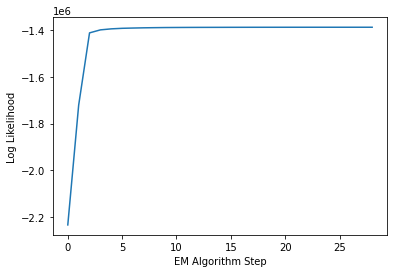

In [9]:
plt.plot(history)
plt.ylabel('Log Likelihood')
plt.xlabel('EM Algorithm Step')
plt.show()

### Matrix Completion

Next, we use our mixture to "fill" the incomplete matrix.

In [10]:
def fill(X,mu,p,var):
    
    post,_ = estep(X,mu,p,var)
    X_pred = X.copy()
    miss_indices = np.where(X == 0)
    X_pred[miss_indices] = (post@mu)[miss_indices]
    
    return X_pred

X_filled = fill(X,mu,p,var)

### Evaluating our Model

Finally we calculate the rmse between the complete and incomplete matrix. (It is important to know that the completed matrix was not used at all up to this point as in real world applications, we would not have access to that data.)

In [11]:
def rmse(X, Y):
    return np.sqrt(np.mean((X - Y)**2))

print('RMSE(incomplete matrix, complete matrix) = ', rmse(X, X_complete))
print('RMSE(GMM-filled matrix, complete matrix) = ', rmse(X_filled, X_complete))

RMSE(incomplete matrix, complete matrix) =  1.6787480867863673
RMSE(GMM-filled matrix, complete matrix) =  0.48253399427052146


The RMSE is much lower, meaning that our filled matrix is now much closer to the completed matrix, the "ground truth", and is a good predictor of how much a viewer would enjoy a movie which they have not previously watched.

## Comparing to sklearn.cluster.KMeans

First, let us define functions for filling the incomplete matrix with the representatives from the KMeans model. The function $\texttt{means-matrix}$ creates a matrix $\texttt{X_means}$ where each sample is replaced with the representative of the cluster is was assigned to. Recall that the representative of a cluster $C$ in KMeans is the mean $\mu(C)$ of the samples in cluster $C$. However, we do not want to replace the non-zero values as we know those values to be true and doing so would certaining increase the total error. Hence, the function $\texttt{fill_zeros}$ replaces the zeros in the incomplete matrix with the value from $\texttt{X_means}$.

In [12]:
def means_matrix(X_original, model):
    
    K,d = model.cluster_centers_.shape
    
    X_new = []
    
    for i in model.labels_:
        
        X_new.append(model.cluster_centers_[i])
        
    return np.array(X_new)
        

def fill_zeros(X_old, X_means):
    
    X_pred = X_old.copy()
    zeros = np.where(X_pred == 0)
    X_pred[zeros] = X_means[zeros]
    
    return X_pred

Then we fit the KMeans model on the incomplete matrix $\texttt{X}$ and use the functions we just created to fill the incomplete matrix. Finally, we compute the RMSE between this filled matrix and the original complete matrix.

In [13]:
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)

X_means = means_matrix(X,kmeans)
X_pred = fill_zeros(X,X_means)
print(rmse(X_pred, X_complete))

0.920752319678606


As we can see our GMM performed better than the KMeans from sklearn.cluster. I encourage the reader to try out different number of clusters by changing $K$ and changing the random seeds. I don't claim that this has not been done before, however, the ability to create your own models from scratch removes the limitation of only being able to use those in popular machine learning libraries. In this case, there are boundless models that could be created with this approach. The obvious one is that we may consider different distributions for the cluster. In particular, I am interested trying not spherical distributions like ellipsoidal distributions and even more general manifolds.